In [1]:
import ecco
import torch
import numpy as np

In [2]:
# let's remember what we modified so we can restore the model

def modify_model_heads(model, layers, heads, memory):
    
    # offset of 1536 is the first value of the Values vector (as in Queries, Keys, Values)
    # The next 64 values constitute the first head in the Values vector - there are 12 heads total in "GPT-2 small" model
    head_offsets = [1536,1536+64,1536+128,1536+192,1536+256,1536+320, \
                    1536+384,1536+448,1536+512,1536+576,1536+640,1536+704]
    
    
    # modify
    # modify heads in all encoder layers
    for layer in layers:
        
        layer = int(layer)
        #print("Modifying layer: ",layer)
        # step through the 12 heads one at a time
        for head in heads:

            # get the offset value for the current head
            offset = head_offsets[head]

            # modify a random 50%
            #np.random.seed(1234)
            #rnd_index = np.random.randint(offset,offset+63,32) # 50% of the heads
            #if head < 3:
            #    print(rnd_index)

            # step through all 768 rows of the c_attn.weight matrix holding Query-Key-Values matrix (768x2304)
            for row in range(0,model.model.transformer.h[layer].attn.c_attn.weight.size()[0]):

                # The line below will do a random deletion
                #model.transformer.h[layer].attn.c_attn.weight[row][rnd_index] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][rnd_index].mul(0.0)
                

                # The line below will randomly shuffle the head corresponding to the "offset" (not really reproducible)
                #random.shuffle(model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31])

                with torch.no_grad():
                    # remember what we modify
                    memory[layer][row][offset:offset + 31] = model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31]
                
                    # The line below will turn all values of the current head to zero (reproducible)
                    # zero out only the first 16/32/48/64 values (25/50/75/100%) of each head
                    model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31] = \
                        model.model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31].mul(0.0)
                
                # The line below will delete the last 50% of the values in each head
                #model.transformer.h[layer].attn.c_attn.weight[row][offset+47:offset + 63] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset+47:offset + 63].mul(0.0)

                # The line below will delete the middle 50% of the values in each head
                #model.transformer.h[layer].attn.c_attn.weight[row][offset+15:offset + 47] = \
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset+15:offset + 47].mul(0.0)

                # let's implement a gradual damage across heads
                # assuming that 
                #if head < 8:
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31] = \
                #        model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31].mul(0.0)
                #if head >= 8:
                #    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 15] = \
                #        model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 15].mul(0.0)
                
    return model, memory



In [3]:
def unmodify_model(model, layers, heads, memory):
     # offset of 1536 is the first value of the Values vector (as in Queries, Keys, Values)
    # The next 64 values constitute the first head in the Values vector - there are 12 heads total in "GPT-2 small" model
    head_offsets = [1536,1536+64,1536+128,1536+192,1536+256,1536+320, \
                    1536+384,1536+448,1536+512,1536+576,1536+640,1536+704]
    
    
    # modify
    # modify heads in all encoder layers
    for layer in layers:
        
        layer = int(layer)
        #print("Un-Modifying layer: ",layer)
        # step through the 12 heads one at a time
        for head in heads:

            # get the offset value for the current head
            offset = head_offsets[head]

            # step through all 768 rows of the c_attn.weight matrix holding Query-Key-Values matrix (768x2304)
            for row in range(memory.shape[1]):

                with torch.no_grad():
                    # The line below will turn all values of the current head to zero (reproducible)
                    # zero out only the first 16/32/48/64 values (25/50/75/100%) of each head
                    model.transformer.h[layer].attn.c_attn.weight[row][offset:offset + 31] = \
                        memory[layer][row][offset:offset + 31]
                
                
    return model


In [4]:
%env CUDA_VISIBLE_DEVICES=1
# Load pre-trained language model. Setting 'activations' to True tells Ecco to capture neuron activations.
lm = ecco.from_pretrained('gpt2', activations=True)
dlm = ecco.from_pretrained('gpt2', activations=True)

layers = [0,1,2,3,4,8]
heads = [0,1,2,3,4,5,6,7,8,9,10,11]
memory = torch.FloatTensor(np.zeros((12,768,2304))).to('cuda')

dlm, mem = modify_model_heads(dlm, layers, heads, memory)




env: CUDA_VISIBLE_DEVICES=1


In [15]:
# Input text
text = "There are two children and their mother in the kitchen."

# Generate 20 tokens to complete the input text.
doutput = dlm.generate(text, generate=20, temperature=1,
                       do_sample=True, top_p=0.9)

# Ecco will output each token as it is generated.

# 'output' now contains the data captured from this run, including the input and output tokens
# as well as neuron activations and input saliency values.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
output = lm.generate(text, generate=20, temperature=1,
                     do_sample=True, top_p=0.9)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# To view the input saliency
output.saliency()

<IPython.core.display.Javascript object>

In [18]:
doutput.saliency()

<IPython.core.display.Javascript object>

In [19]:
# to view input saliency with more details (a bar and % value for each token)
output.saliency(style="detailed")

<IPython.core.display.Javascript object>

In [6]:
# We can run non-negative matrix factorization using run_nmf. We pass the number of factors/components to break down into
nmf_1 = output.run_nmf(n_components=10)

# nmf_1 now contains the necessary data to create the interactive nmf explorable:
nmf_1.explore()

<IPython.core.display.Javascript object>

/home/lixx3013/anaconda3/lib/python3.7/site-packages/ecco/output.py:412: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_id = torch.tensor(self.token_ids[0][self.n_input_tokens + j])


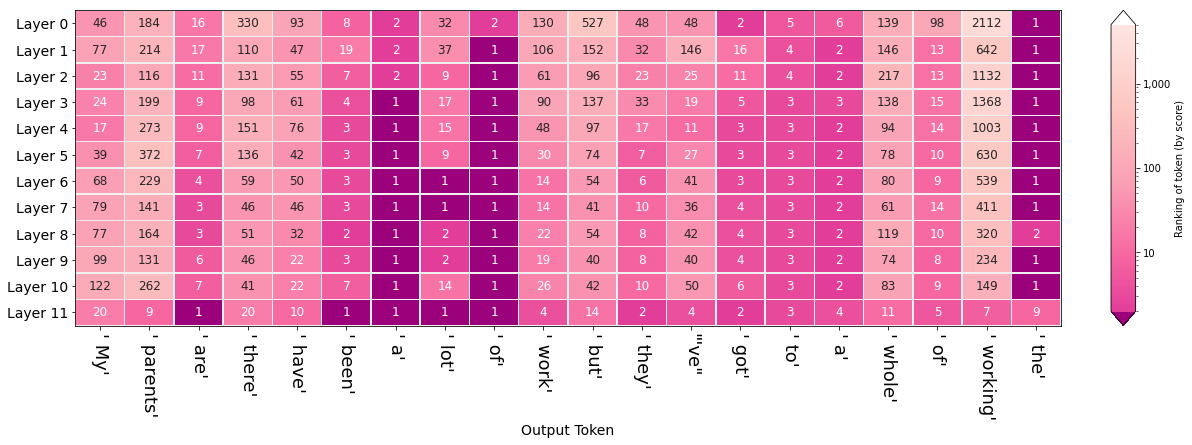

In [21]:
doutput.rankings()